In [1]:
import trackpy as tp
import os
import pandas as pd
import numpy as np
import numba
import matplotlib.pyplot as plt
import pickle
import cv2
import math
from datetime import date
import time
from IPython.display import display
import ipywidgets as widgets
import re
import scipy.optimize as sco
import seaborn
import tkinter as tk
from tkinter import filedialog
import warnings
warnings.filterwarnings(action='once')

In [2]:
folderlist = [r'G:\Shared drives\Horowitz Lab Notes\Rebecca Dalphin and Alex Axton\Analysis\2023-05-27',
             r'G:\Shared drives\Horowitz Lab Notes\Rebecca Dalphin and Alex Axton\Analysis\2023-05-28']

savefolder = r'G:\Shared drives\Horowitz Lab Notes\Rebecca Dalphin and Alex Axton\Analysis'

subtract_drift_slow = False
calculate_van_hove_slow = False

# scaling, measured in microns per pixel
#scaling = 330 / 1247.96 # 20x1.0, measured 2021-06-17
#scaling = 220 / 1250.04 # 20x1.5, measured 2021-06-17
scaling = 150 / 1127.54 # 40x1.0, measured 2021-06-16
#scaling = 100 / 1130.61 # 40x1.5, measured 2021-06-16
#scaling = 80 / 914.92 # 60x1.0, measured 2021-05-28
#scaling = 60 / 1031.07 # 60x1.5, measured 2021-05-28

In [3]:
df_list = []
filename_list = []
fps_list = []

"""
Note about file names
unfiltered.pkl = every particle trajectory, immediately after it was linked.
.pkl = filtered to remove stubs
nodrift.pkl = drift has been subtracted
"""



for folder in folderlist:
    os.chdir(folder)
    # Iterate over files in the folder
    for filename in os.listdir(folder):
        if filename.endswith('control_tracer.pkl'):
            print(filename)
            df_list.append(pd.read_pickle(filename))
            filename_list.append(os.path.join(folder,filename))
            
#filename_list

Data Taken 2023-05-26, 2000 PEG @ 25mg per mL (3)control_tracer.pkl
Data Taken 2023-05-26, 2000 PEG @ 25mg per mL (2)control_tracer.pkl
Data Taken 2023-05-26, 2000 PEG @ 25mg per mL (1)control_tracer.pkl
Data Taken 2023-05-26, 20,000 PEG @ 25mg per mL (3)control_tracer.pkl
Data Taken 2023-05-26, 20,000 PEG @ 25mg per mL (2)control_tracer.pkl
Data Taken 2023-05-26, 20,000 PEG @ 25mg per mL (1)control_tracer.pkl
Data Taken 2023-05-26, 200 PEG @ 25mg per mL (3)control_tracer.pkl
Data Taken 2023-05-26, 200 PEG @ 25mg per mL (2)control_tracer.pkl
Data Taken 2023-05-26, 200 PEG @ 25mg per mL (1)control_tracer.pkl
Data Taken 2023-05-26, 20,000 PEG @ 25mg per mL (3)control_tracer.pkl
Data Taken 2023-05-26, 200 PEG @ 40% (3)control_tracer.pkl
Data Taken 2023-05-26, 200 PEG @ 40% (2)control_tracer.pkl
Data Taken 2023-05-26, 200 PEG @ 40% (1)control_tracer.pkl
Data Taken 2023-05-27, 200 and 2000 PEG @ 25mg per mL (1)control_tracer.pkl
Data Taken 2023-05-26, 8000  PEG @ 25mg per mL (3)control_trac

In [4]:
def extract_short_file(filepath):
    match = re.search(r'Data Taken (\d{4}-\d{2}-\d{2}), (.*)control_tracer.pkl', filepath)
    if match:
        extracted_part = match.group(2).strip()
    else:
        base_name = os.path.basename(filepath)  # Get the base name from the path
        start_index = base_name.rfind(',') + 2  # Find the index of the comma and add 2 to skip the comma and space
        extracted_part = base_name[start_index:].replace("control_tracer.pkl", "").strip()  # Remove "control_tracer.pkl" and leading/trailing spaces
    return extracted_part

shortfiles = [extract_short_file(item) for item in filename_list]
shortfiles

['2000 PEG @ 25mg per mL (3)',
 '2000 PEG @ 25mg per mL (2)',
 '2000 PEG @ 25mg per mL (1)',
 '20,000 PEG @ 25mg per mL (3)',
 '20,000 PEG @ 25mg per mL (2)',
 '20,000 PEG @ 25mg per mL (1)',
 '200 PEG @ 25mg per mL (3)',
 '200 PEG @ 25mg per mL (2)',
 '200 PEG @ 25mg per mL (1)',
 '20,000 PEG @ 25mg per mL (3)',
 '200 PEG @ 40% (3)',
 '200 PEG @ 40% (2)',
 '200 PEG @ 40% (1)',
 '200 and 2000 PEG @ 25mg per mL (1)',
 '8000  PEG @ 25mg per mL (3)',
 '8000  PEG @ 25mg per mL (2)',
 '8000  PEG @ 25mg per mL (1)',
 '8000 and 20000 PEG @ 25mg per mL (3)',
 '8000 and 20000 PEG @ 25mg per mL (2)',
 '8000 and 20000 PEG @ 25mg per mL (1)',
 '200 and 2000 PEG @ 25mg per mL (2)',
 'All PEG length @ 25mg per mL (3)',
 'All PEG length @ 25mg per mL (2)',
 'All PEG length @ 25mg per mL (1)']

In [5]:
import av


def get_fps_from_avi(avi_file): # avi_file is a file path
    try:
        video = cv2.VideoCapture(avi_file)
        fps = video.get(cv2.CAP_PROP_FPS)
        video.release()
    except:
        import av
        container = av.open(avi_file)
        fps = container.streams.video[0].average_rate
        container.close()
    return float(fps)

os.chdir(r'G:\Shared drives\Horowitz Lab Notes\Rebecca Dalphin and Alex Axton')
for filename in os.listdir(r'G:\Shared drives\Horowitz Lab Notes\Rebecca Dalphin and Alex Axton'):
    #print(filename)
    if filename.endswith('.avi'):
        fps = get_fps_from_avi(filename)
        print(fps)


24.404
24.404
24.404
24.404
24.404
24.404
24.404
24.404
24.404
24.404
24.404
24.404
24.404
24.404
24.404
24.404
24.404
24.404
24.404
24.404
24.404
24.404
24.404
24.404
24.404
24.404
24.404


In [6]:
os.chdir(savefolder)

if subtract_drift_slow:
    from rotational_drift_subtraction import drift_subtract
    
    warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
    # Some day this will come back to bite me. Today is not that day.


    df_list_nodrift = []
    for df in df_list:
        _, df_nodrift = drift_subtract(tracer = df, show_plots=False )
        df_list_nodrift.append(df_nodrift)


    # Re-enable the warning
    warnings.filterwarnings("default", category=PendingDeprecationWarning)
    
    data_dict = {'filename_list': filename_list, 'df_list_nodrift':df_list_nodrift}
    with open('drift_subtracted_trajectories_dictionary.pkl', 'wb') as file:
        pickle.dump(data_dict, file)
else:
    with open('drift_subtracted_trajectories_dictionary.pkl', 'rb') as file:
        data_dict = pickle.load(file)
    # Extract elements from the dictionary
    filename_list = data_dict['filename_list']
    df_list_nodrift = data_dict['df_list_nodrift']

In [7]:
debug = False

if debug and len(filename_list) == len(df_list_nodrift):
    df_list_nodrift_orig = df_list_nodrift.copy()
    df_list_nodrift = df_list_nodrift[:4]

In [8]:
"""
Normalizes histogram data so that the sum of probabilities is one.

@param histdata - the starting histogram

@return the normalized histogram of probabilites
"""
def manualnorm(histdata):
     return (1/(histdata.sum()*binwidth))*histdata
    
"""
Outputs f(x) where f is a Gaussian curve.

@param x - the independent variable
@param a - Gaussian amplitude
@param b - Gaussian center
@param c - Gaussian width

@return f(x)
"""
def gaussian(x,a,b,c):
    return a*(np.exp(-((x-b)**2)/(2*(c**2))))

In [9]:
calculate_van_hove_slow = False

In [10]:
if calculate_van_hove_slow:
    maxlagtime = 40  # in number of frames
    skip = int(maxlagtime / 5)
    vanhove_max_x = 4
    binwidth = 0.04
    figsize = [8, 8]

    show_plot = False

    start_time = time.time()
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    # initializations before for loop
    binsequence = np.arange(-vanhove_max_x, vanhove_max_x, binwidth)
    trackshistlistlist = []
    trackshistlistlisty = []  # Added trackshistlistlisty
    kurtosisdflist = []
    kurtosisdflisty = []  # Added kurtosisdflisty
    lagtimelist = []
    color_mapping = {}
    numplots = int(maxlagtime / skip)
    i = 0
    if show_plot:
        fig, axs = plt.subplots(int(math.ceil(numplots / 5)), 5, figsize=figsize, dpi=300)
        fig2, ax2 = plt.subplots(1, 1, figsize=figsize, dpi=300)

    assert len(shortfiles) == len(df_list_nodrift)

    for (file, filepath, df, ii) in zip(shortfiles, filename_list, df_list_nodrift, range(len(shortfiles))):
        base_filename = re.sub(r'\(\d\)$', '', file).strip()

        if base_filename not in color_mapping:
            color_mapping[base_filename] = plt.rcParams['axes.prop_cycle'].by_key()['color'][i % len(plt.rcParams['axes.prop_cycle'])]
            i += 1

        color = color_mapping[base_filename]

        tracksbyframex = df.set_index(['frame', 'particle'])['x'].unstack()
        tracksbyframey = df.set_index(['frame', 'particle'])['y'].unstack()
        trackshistlist = []
        trackshistlisty = []  # Added trackshistlisty
        klist = []
        kylist = []
        tlist = []
        j = 0
        for vanhove_lagtime_inframes in range(1, maxlagtime + 1, skip):
            if ii == 0:
                lagtimelist.append(vanhove_lagtime_inframes / fps)
            plt.sca(axs.flat[j])
            plt.title("{:.2f} ms".format(1000 * vanhove_lagtime_inframes / fps))

            # calculate vanhove / probability distribution function
            trackshist = manualnorm(tp.motion.vanhove(
                tracksbyframex, lagtime=vanhove_lagtime_inframes, mpp=scaling, bins=binsequence, ensemble=True))
            trackshist.name = 'x Probability distribution'
            trackshisty = manualnorm(tp.motion.vanhove(
                tracksbyframey, lagtime=vanhove_lagtime_inframes, mpp=scaling, bins=binsequence, ensemble=True))
            trackshisty.name = 'y Probability distribution'
            if show_plot:
                trackshist.plot(ax=axs.flat[j], label=file, color=color)
                trackshisty.plot(ax=axs.flat[j], label=file, color=color)
            trackshistlist.append(trackshist)
            trackshistlisty.append(trackshisty)

            kx = trackshist.kurtosis()
            klist.append(kx)
            ky = trackshisty.kurtosis()
            kylist.append(ky)
            tlist.append(vanhove_lagtime_inframes / fps)
            j += 1

        kurtosisdf = pd.DataFrame({'time (s)': tlist, file + ' kurtosis': klist})
        kurtosisdfy = pd.DataFrame({'time (s)': tlist, file + ' kurtosis': kylist})
        if show_plot:
            plt.sca(ax2)
            plt.xlabel('lag time (s)')
            plt.ylabel('kurtosis')
            kurtosisdf.set_index('time (s)').plot(label=file, ax=ax2, color=color)

        trackshistlistlist.append(trackshistlist)
        trackshistlistlisty.append(trackshistlisty)  # Added trackshistlistlisty
        kurtosisdflist.append(kurtosisdf)
        kurtosisdflisty.append(kurtosisdfy)  # Added kurtosisdflisty

    if show_plot:
        ax2.set_yscale('log')
        plt.ylabel('kurtosis')

        # I want to consolidate the figure legend to just the unique filenames (not counting (1), (2), (3))
        # Get the legend handles and labels
        legend_handles, legend_labels = ax2.get_legend_handles_labels()

        # Extract the short file names using regular expressions
        short_labels = []
        handle_mapping = {}

        for handle, label in zip(legend_handles, legend_labels):
            match = re.search(r'(.+?) \(\d+\) kurtosis', label)
            if match:
                short_label = match.group(1)
                if short_label not in handle_mapping:
                    handle_mapping[short_label] = handle
                    short_labels.append(short_label)
            else:
                short_labels.append(label)

        # Create new handles using the handle mapping dictionary
        new_handles = [handle_mapping[label] for label in short_labels]

        # Set the modified handles and labels
        ax2.legend(new_handles, short_labels, bbox_to_anchor=(1, 1), loc='upper left')  # Move the legend to the right

        plt.show()

    warnings.filterwarnings("default", category=RuntimeWarning)
    warnings.filterwarnings("default", category=DeprecationWarning)

    ## Saving results
    # Create a dictionary to save
    data_dict_vanhove = {
        'filename_list': filename_list,
        'binsequence': binsequence,
        'trackshistlistlist': trackshistlistlist,
        'trackshistlistlisty': trackshistlistlisty,
        'kurtosisdflist': kurtosisdflist,
        'kurtosisdflisty': kurtosisdflisty,
        'lagtimelist': lagtimelist,
        'maxlagtime': maxlagtime,
        'skip': skip,
        'scaling': scaling,
        'fps': fps,
    }

    today = date.today().isoformat()  # Get today's date in ISO format
    pickle_file = f'data_dict_vanhove_{today}_{len(lagtimelist)}lagtimes.pkl'  # Create the pickle file name

    os.chdir(savefolder)
    # Save the dictionary to a pickle file
    with open(pickle_file, 'wb') as f:
        pickle.dump(data_dict_vanhove, f)

    # calculate_van_hove_slow = False

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print("Execution time:", execution_time_minutes, "minutes")
else:  # open saved file
    root = tk.Tk()  # Create a Tkinter root window
    root.lift()
    root.withdraw()  # Hide the root window

    print('Look for the file dialogue window!')

    # Open the file dialog to select the pickle file
    file_path = filedialog.askopenfilename(filetypes=[("Pickle Files", "*.pkl")])

    # Check if a file was selected
    if file_path:
        # Process the selected pickle file
        with open(file_path, 'rb') as f:
            data_dict_vanhove = pickle.load(f)
        # Extract the variables from the dictionary
        filename_list = data_dict_vanhove['filename_list']
        binsequence = data_dict_vanhove['binsequence']
        trackshistlistlist = data_dict_vanhove['trackshistlistlist']
        trackshistlistlisty = data_dict_vanhove['trackshistlistlisty']
        kurtosisdflist = data_dict_vanhove['kurtosisdflist']
        kurtosisdflisty = data_dict_vanhove['kurtosisdflisty']
        lagtimelist = data_dict_vanhove['lagtimelist']  # in seconds
        maxlagtime = data_dict_vanhove['maxlagtime']  # in number of frames
        skip = data_dict_vanhove['skip']  # in number of frames
        scaling = data_dict_vanhove['scaling']  # in microns per pixel
        fps = data_dict_vanhove['fps']  # in Hz
        print('Loaded file', file_path)
    else:
        print("No file selected.")


Look for the file dialogue window!
Loaded file G:/Shared drives/Horowitz Lab Notes/Rebecca Dalphin and Alex Axton/Analysis/data_dict_vanhove_2023-06-16_5lagtimes.pkl


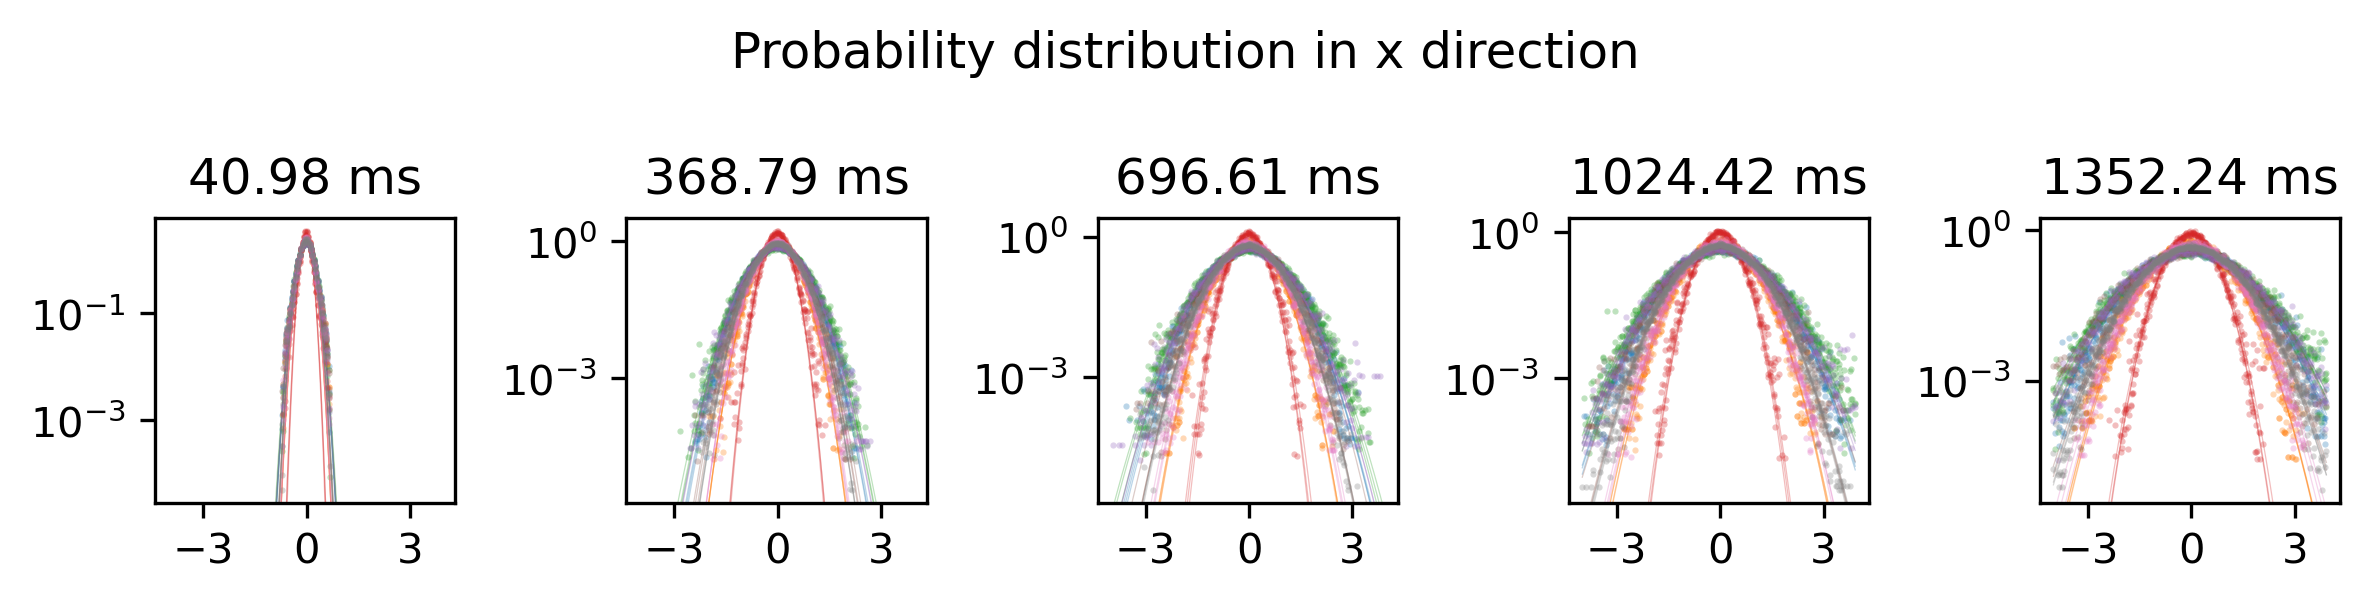

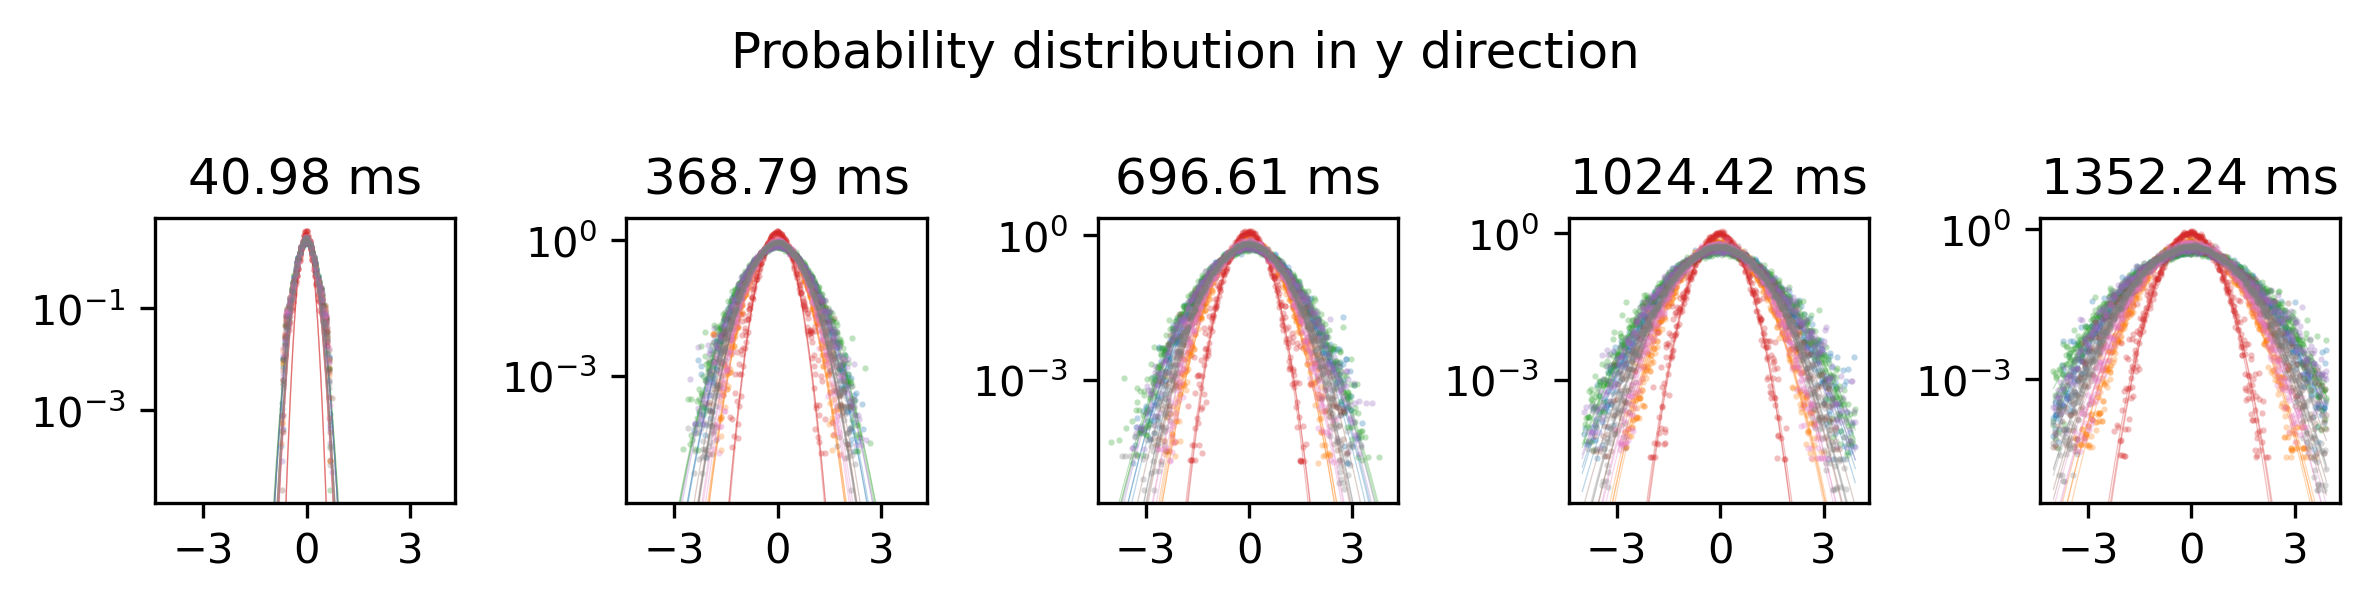

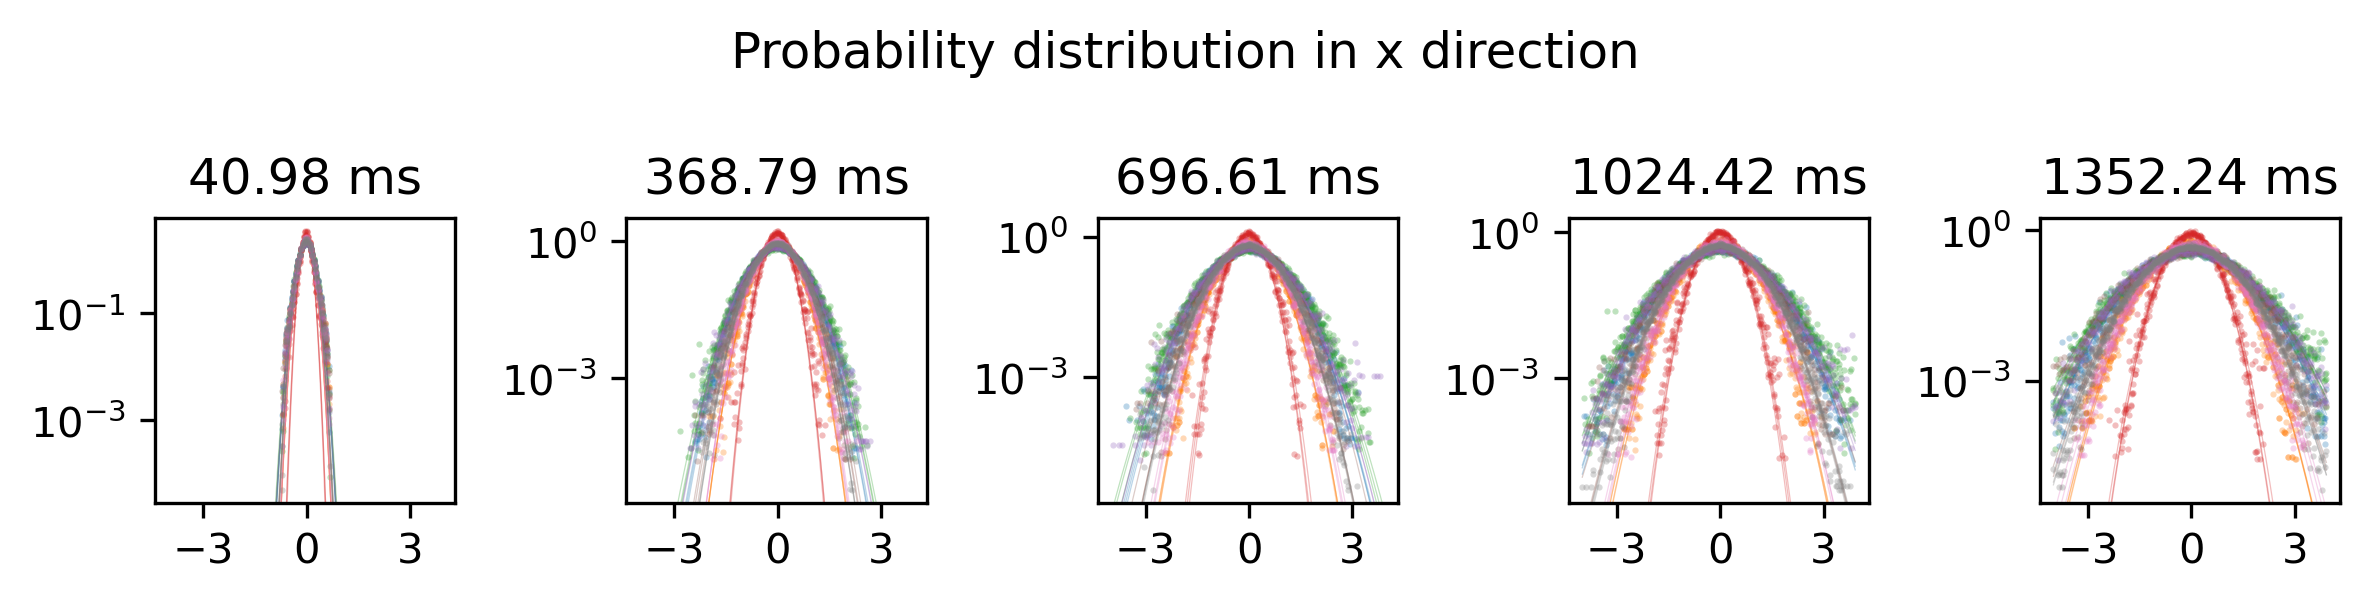

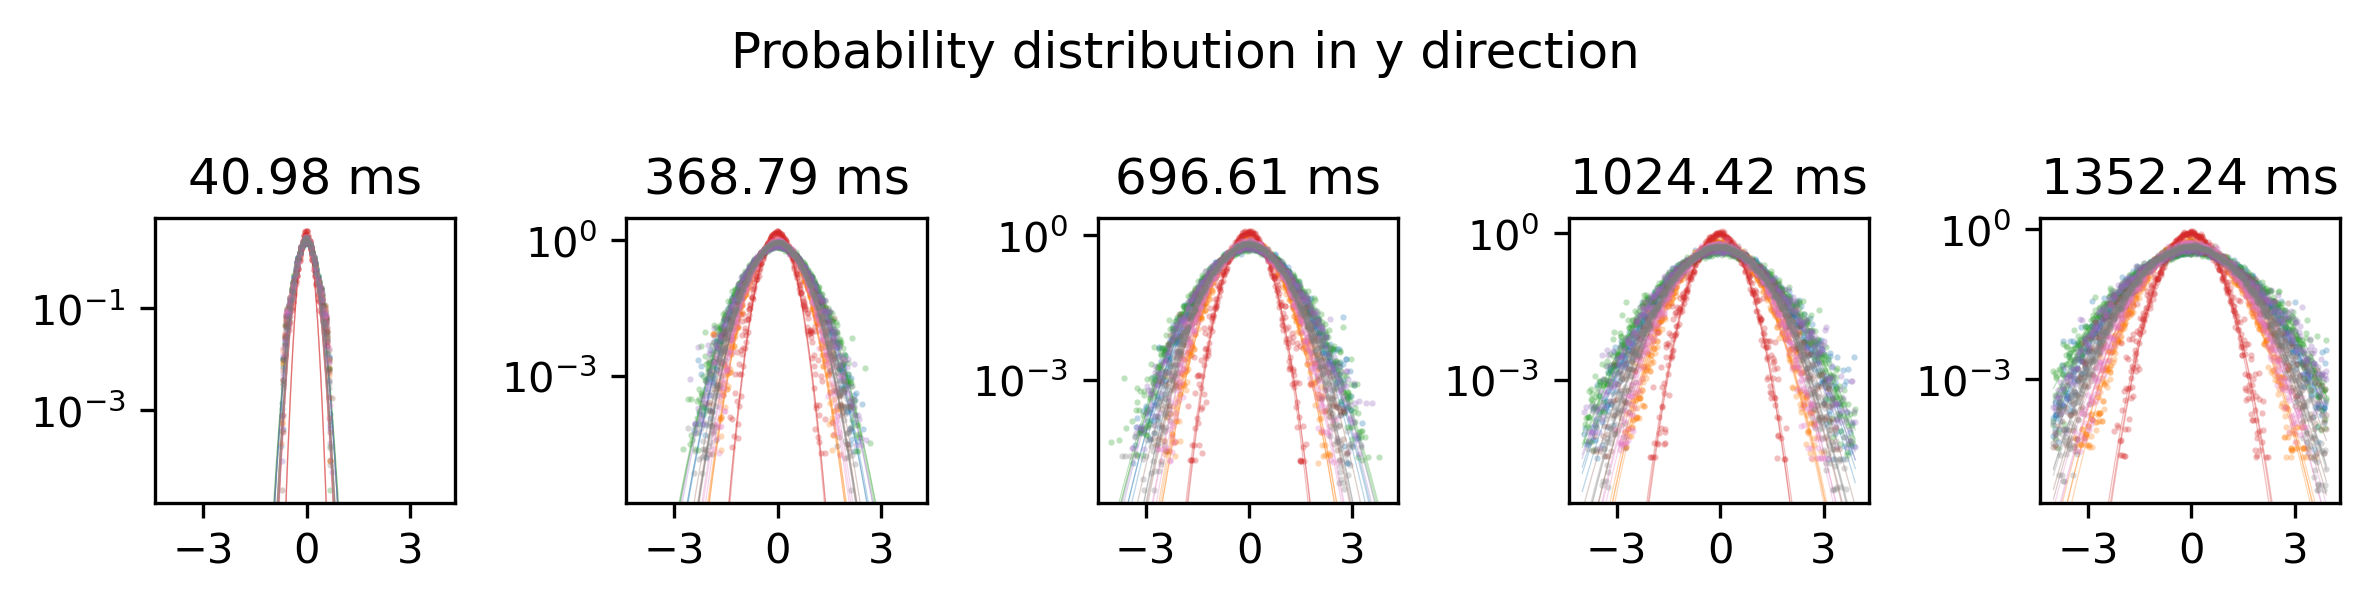

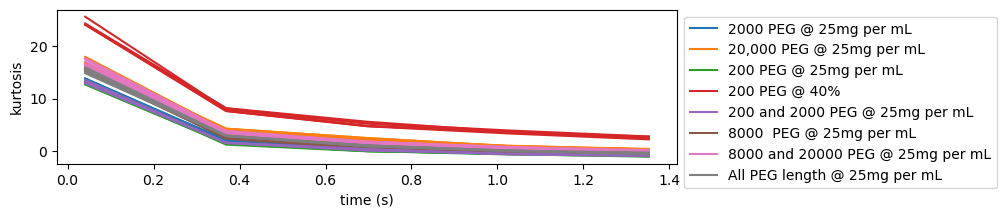

In [45]:
# Plot previously calculated probability distribution function


show_curvefit = True
figsize = [8, 2]

assert len(filename_list) == len(trackshistlistlist)
assert len(filename_list) == len(trackshistlistlisty)
assert len(filename_list) == len(kurtosisdflist)
assert len(filename_list) == len(kurtosisdflisty)

numplots = int(maxlagtime / skip)
fig, axs = plt.subplots(int(math.ceil(numplots / 5)), 5, figsize=figsize, dpi=300)
fig3, axsy = plt.subplots(int(math.ceil(numplots / 5)), 5, figsize=figsize, dpi=300)

fig.suptitle('Probability distribution in x direction')
fig3.suptitle('Probability distribution in y direction')

fig2, ax2 = plt.subplots(1, 1, figsize=figsize)

color_mapping = {}
if not show_curvefit:
    xlimx = np.zeros_like(axs.flat)
    xlimy = np.zeros_like(axs.flat)
    ylimx =  np.zeros_like(axsy.flat)
    ylimy =  np.zeros_like(axsy.flat)
i = 0

warnings.filterwarnings("ignore", category=DeprecationWarning) # Not my fault. There's some dependency.


for file, trackshistlist, trackshistlisty, kurtosisdf, kurtosisdfy, gaussian_fit_paramsxlist, gaussian_fit_paramsylist in zip(
    shortfiles, trackshistlistlist, trackshistlistlisty, kurtosisdflist, kurtosisdflisty, gaussian_fit_paramsxlistlist, gaussian_fit_paramsylistlist
):
    # Vary colors if base_filename is different
    base_filename = re.sub(r"\(\d\)$", "", file).strip()
    if base_filename not in color_mapping:
        color_mapping[base_filename] = plt.rcParams["axes.prop_cycle"].by_key()["color"][
            i % len(plt.rcParams["axes.prop_cycle"])
        ]
        i += 1
    color = color_mapping[base_filename]

    j = 0
    
    for vanhove_lagtime_insecs, trackshist, trackshisty, gaussian_fit_paramsx, gaussian_fit_paramsy in zip(
        lagtimelist, trackshistlist, trackshistlisty, gaussian_fit_paramsxlist, gaussian_fit_paramsylist
    ):
        if show_curvefit:
            try:
                gaussian_fitx = gaussian(trackshist.index, gaussian_fit_paramsx[0],
                                         gaussian_fit_paramsx[1], gaussian_fit_paramsx[2])
                gaussian_fity = gaussian(trackshisty.index, gaussian_fit_paramsy[0],
                                         gaussian_fit_paramsy[1], gaussian_fit_paramsy[2])

                (axs.flat[j]).plot(trackshist.index, gaussian_fitx, color=color, linewidth=0.3, alpha=0.3)
                (axsy.flat[j]).plot(trackshisty.index, gaussian_fity, color=color, linewidth=0.3, alpha=0.3)

                try:
                    (axs.flat[j]).set_xlim(xlimx[j])
                    (axs.flat[j]).set_ylim(ylimx[j])
                    (axsy.flat[j]).set_xlim(xlimy[j])
                    (axsy.flat[j]).set_ylim(ylimy[j])
                except:
                    pass
            except:
                print('Failed to show Gaussian fits.')
        
        # Plot vanhove datapoints 
        trackshist.plot(
            marker=".",
            markersize=1,
            linestyle="",
            ax=axs.flat[j],
            label=file + " x",
            color=color,
            alpha=0.3,
        )

        trackshisty.plot(
            marker=".",
            markersize=1,
            linestyle="",
            ax=axsy.flat[j],
            label=file + " y",
            color=color,
            alpha=0.3,
        )

        for ax in [axs.flat[j], axsy.flat[j]]:
            ax.set_title("{:.2f} ms".format(1000 * vanhove_lagtime_insecs))
            ax.set_xticks([int(trackshist.index.min())+1, 0, int(trackshist.index.max())])
            ax.set_yscale("log")
        if not show_curvefit:
            xlimx[j] = axs.flat[j].get_xlim()
            ylimx[j] = axs.flat[j].get_ylim()
            xlimy[j] = axsy.flat[j].get_xlim()
            ylimy[j] = axsy.flat[j].get_ylim()
        j += 1

    kurtosisdf.set_index("time (s)").plot(ax=ax2, color=color, label=file + " x")
    kurtosisdfy.set_index("time (s)").plot(ax=ax2, color=color, label=file + " y")

warnings.resetwarnings()

fig3.tight_layout()
fig.tight_layout()

plt.sca(ax2)
plt.ylabel("kurtosis")

# Consolidate the figure legend to just the unique filenames (not counting (1), (2), (3))

handles, legend_labels = ax2.get_legend_handles_labels()
short_labels = []
handle_mapping = {}
for handle, label in zip(handles, legend_labels):
    match = re.search(r'(.+?) \(\d+\) kurtosis', label)  # Extract the short file names using regular expressions
    if match:
        short_label = match.group(1)
        if short_label not in handle_mapping:
            handle_mapping[short_label] = handle
            short_labels.append(short_label)
    else:
        short_labels.append(label)

new_handles = [handle_mapping[label] for label in short_labels]  # Create new handles using the handle mapping dictionary

# Set the modified handles and labels
ax2.legend(handles=new_handles, labels=short_labels, bbox_to_anchor=(1, 1), loc='upper left')  # Move the legend to the right
